</b> Trying Generative RNN for new molecule generation </b>

I have done this project during the seminar classroom at my department. 

This is very basic work trying to explore new chemical generation using generative model approach.

This time we will use the small part from https://zinc.docking.org/ (around 750,000)

In [2]:
!pip install selfies

In [3]:
import selfies as sf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from dataclasses import dataclass

In [4]:
# Read the dataset 
pd_data = pd.read_csv('dataJ_250k_rndm_zinc_drugs_clean.txt')
print("Total data size", len(pd_data))

Total data size 249455


In [5]:
# Turing the way we represent molecule from SMILES string to SELFIES strings for representing the molecule
# Self-Referencing Embedded Strings
selfies_list = [sf.encoder(s) for s in pd_data.iloc[:, 0]]

In [6]:
print(selfies_list[100])

[C][C][C][C][C][=C][Branch2][Ring1][=Branch1][C][=Branch1][C][=O][N][N][C][=Branch1][C][=O][C][=C][C][=C][C][Branch1][C][Br][=C][Ring1][#Branch1][NH1][N][=Ring2][Ring1][C]


In [7]:
# Tokenization of Self-Referencing Embedded Strings
selfies_symbol_counts = {"[nop]": 0}


def parse(s):
    for si in s.split("[")[1:]:
        token = "[" + si
        if token in selfies_symbol_counts:
            selfies_symbol_counts[token] += 1
        else:
            selfies_symbol_counts[token] = 0


[parse(s) for s in selfies_list]


sorted_token_counts = list(sorted(selfies_symbol_counts.items(), key=lambda i: -i[1]))
for p in sorted_token_counts[:10]:
    print(*p)

[C] 3533632
[=C] 1124758
[Ring1] 858765
[Branch1] 621080
[=Branch1] 523631
[N] 508933
[=O] 318168
[O] 279513
[Branch2] 202232
[Ring2] 177924


In [8]:
vocab = list(selfies_symbol_counts.keys())
vocab_stoi = {o: i for o, i in zip(vocab, range(len(vocab)))}


def selfies2ints(s):
    result = []
    for si in s.split("[")[1:]:
        result.append(vocab_stoi["[" + si])
    return result


def ints2selfies(v):
    return "".join([vocab[i] for i in v])


# test them out
s = selfies_list[0]
print("selfies:", s)
v = selfies2ints(s)
print("selfies2ints:", v)
so = ints2selfies(v)
print("ints2selfes:", so)
assert so == s

selfies: [C][C@@H1][C][C][Branch2][Ring1][Ring2][N][C][=C][N][=C][C][Branch1][=Branch2][C][=N][N][=C][N][Ring1][Branch1][C][=C][Ring1][N][C][C@@H1][Branch1][C][C][C][Ring2][Ring1][Ring2]
selfies2ints: [1, 2, 1, 1, 3, 4, 5, 6, 1, 7, 6, 7, 1, 8, 9, 1, 10, 6, 7, 6, 4, 8, 1, 7, 4, 6, 1, 2, 8, 1, 1, 1, 5, 4, 5]
ints2selfes: [C][C@@H1][C][C][Branch2][Ring1][Ring2][N][C][=C][N][=C][C][Branch1][=Branch2][C][=N][N][=C][N][Ring1][Branch1][C][=C][Ring1][N][C][C@@H1][Branch1][C][C][C][Ring2][Ring1][Ring2]


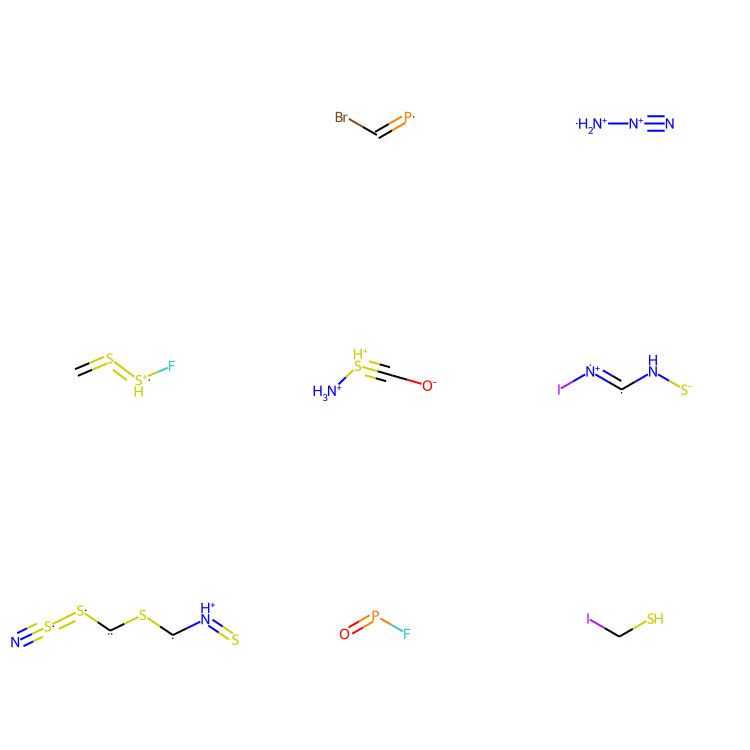

In [10]:
#Drawing the molecule
def model1():
    # pick random length
    length = np.random.randint(1, 100)
    seq = np.random.choice(len(vocab), size=length)
    return seq
def draw_examples(model, count=10):
    examples = [ints2selfies(model()) for _ in range(9)]
    examples_smiles = [sf.decoder(s) for s in examples]
    from rdkit.Chem import rdDepictor

    examples_mols = [rdkit.Chem.MolFromSmiles(s) for s in examples_smiles]
    return rdkit.Chem.Draw.MolsToGridImage(
        examples_mols, molsPerRow=3, subImgSize=(250, 250)
    )


draw_examples(model1)

</b> Building model using RNN with self-supervised learning </b>

In [11]:
# Define Hyperparamter class
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=64,
    buffer_size=10000,
    embedding_dim=256,
    rnn_units=128,
)

In [12]:
# Training Data Construction
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list]
# Keras pads with 0s - [nop] in our vocab
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")

# Now build dataset
seqs_data = tf.data.Dataset.from_tensor_slices((padded_seqs,))


def split_input_target(sequence):
    # prefix with [nop]
    input_text = tf.concat(([0], sequence[:-1]), 0)
    target_text = sequence
    return input_text, target_text

In [13]:
data = seqs_data.map(split_input_target)
data = (
    data.shuffle(config.buffer_size)
    .batch(config.batch_size, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
# grab examples
for d in data:
    example = d[0]
    example_y = d[1]
    break

In [14]:
#Model construction
x = tf.keras.Input(shape=(None,))
ex = tf.keras.layers.Embedding(
    input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
)(x)

h = tf.keras.layers.GRU(
    config.rnn_units, return_sequences=True, reset_after=False, stateful=False
)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
train_model = tf.keras.Model(inputs=x, outputs=yhat)

In [15]:
train_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         27648     
                                                                 
 gru (GRU)                   (None, None, 128)         147840    
                                                                 
 dense (Dense)               (None, None, 108)         13932     
                                                                 
Total params: 189,420
Trainable params: 189,420
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Training 
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
train_model.compile(tf.optimizers.Adam(1e-2), loss=loss)
result = train_model.fit(data, epochs=2, verbose=0)

In [17]:
#Inference
x = tf.keras.Input(shape=(None,), batch_size=1)
ex = tf.keras.layers.Embedding(
    input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
)(x)
h = tf.keras.layers.GRU(
    config.rnn_units, return_sequences=False, reset_after=False, stateful=True
)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
inference_model = tf.keras.Model(inputs=x, outputs=yhat)

inference_model.set_weights(train_model.get_weights())

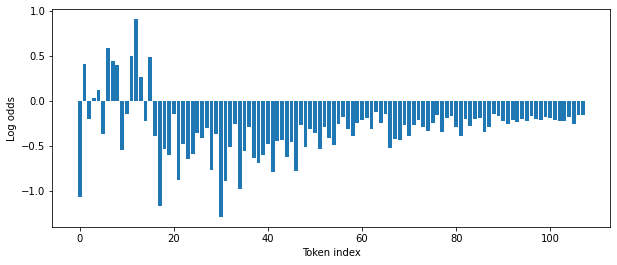

In [18]:
plt.figure(figsize=(10, 4))
x = np.array([0]).reshape(1, 1)
v = inference_model.predict(x, verbose=0)
plt.bar(x=np.arange(config.vocab_size), height=np.squeeze(v))
plt.xlabel("Token index")
plt.ylabel("Log odds")
plt.show()